# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21


def batch_simulator_augment01(prior_samples, n_obs):   
    """
    Simulate multiple oscillation model datasets with missing values and augmentation by zeros/ones
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        sim_data[m, :, 0] = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
        
    return sim_data   


def batch_simulator_timepoints(prior_samples, n_obs):   
    """
    Simulate multiple oscillation model datasets with missing values and time labels (present time points)
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    n_missing = np.random.randint(0, missing_max+1)
    n_present = n_obs - n_missing
    sim_data = np.empty((n_sim, n_present, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_present observations
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing)
        present_indices = np.setdiff1d(range(n_obs), missing_indices)
        present_timepoints = time_points[present_indices]
        sim_data[m, :, 0] = np.sin(a*2*np.pi*present_timepoints) + b + np.random.normal(0, sigma, size=n_present)
        sim_data[m, :, 1] = present_timepoints   # time labels
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
true_params = prior(500) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

In [6]:
# Augment01
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts', 
                                     skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=1000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), true_params)
a1 = display_metrics(v_augment01)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
NRMSE(k_1): 0.001 ± 0.000
NRMSE(k_2): 0.008 ± 0.000
R²(k_1): 1.000 ± 0.000
R²(k_2): 0.998 ± 0.000


In [7]:
# Timepoints
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts', 
                                     skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_timepoints = np.empty((500, 1000, 2), dtype=np.float32)
for m in range(500):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_timepoints = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_timepoints[0, :, 0] = x_augment01[m, present_indices, 0]
    x_timepoints[0, :, 1] = time_points[present_indices]
    param_samples_timepoints[m] = amortizer.sample(x_timepoints, n_samples=1000)
v_timepoints = bootstrap_metrics(np.swapaxes(param_samples_timepoints, 0, 1), true_params)
a3 = display_metrics(v_timepoints)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
NRMSE(k_1): 0.014 ± 0.003
NRMSE(k_2): 0.013 ± 0.001
R²(k_1): 0.997 ± 0.001
R²(k_2): 0.995 ± 0.001


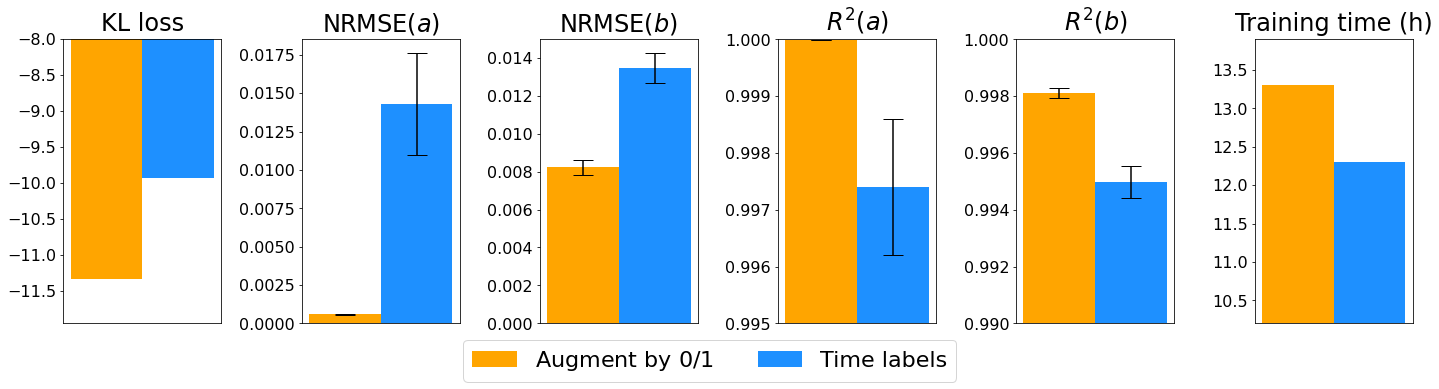

In [20]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
plt.rcParams['font.size'] = 16

bar_chart(ax, np.array([-11.338, -9.929]), 0, 'KL loss', y_lim=np.array([-11.95, -8]))
bar_chart(ax, np.array([a1[0,0], a3[0,0]]), 1, 'NRMSE$(a)$', 
          se=np.array([a1[1,0], a3[1,0]]), y_lim=None)
bar_chart(ax, np.array([a1[0,1], a3[0,1]]), 2, 'NRMSE$(b)$', 
          se=np.array([a1[1,1], a3[1,1]]), y_lim=None)
bar_chart(ax, np.array([a1[0,2], a3[0,2]]), 3, '$R^2(a)$', 
          se=np.array([a1[1,2], a3[1,2]]), 
          y_lim=np.array([0.995, 1.]), y_ticks=None)
bar_chart(ax, np.array([a1[0,3], a3[0,3]]), 4, '$R^2(b)$', 
          se=np.array([a1[1,3], a3[1,3]]), 
          y_lim=np.array([0.99, 1.]), y_ticks=None)
bar_chart(ax, np.array([13+18/60, 12+18/60]), 5, 'Training time (h)', 
          y_lim=np.array([10.2, 13.9]), y_ticks=np.array([10.5, 11, 11.5, 12, 12.5, 13, 13.5]))

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.12), ncol=2, fontsize=22.25)
plt.tight_layout()
plt.show()
fig.savefig("figures/{}_bar_chart.png".format('Oscillation'), dpi=600, bbox_inches='tight')

SBC plot: similarly good => no systematic bias